In [20]:
import importlib
import os, pandas as pd, numpy as np
from joblib import dump, load
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
# from sod.core.evaluation import normalize
import sod.core.dataset as sod_core_dataset
importlib.reload(sod_core_dataset)
import sod.core.plot as sod_plot
importlib.reload(sod_plot)

print('LOADING train and test set into pandas dataframes')
print()

print('Allset train')
allset_train = sod_core_dataset.open_dataset('allset_train.hdf', normalize=False, verbose=False)
print(sod_core_dataset.dfinfo(allset_train))

print()
print('Dataframe UID columns (used for uniquely identify each segment)')
print(sod_core_dataset.dataset_info(allset_train).uid_columns)

print()
print('Dataframe columns')
print(list(allset_train.columns))

print()
print('Allset test')
allset_test = sod_core_dataset.open_dataset('allset_test.hdf', normalize=False, verbose=False)
print(sod_core_dataset.dfinfo(allset_test))

print()
print('Dataframe UID columns (used for uniquely identify each segment)')
print(sod_core_dataset.dataset_info(allset_test).uid_columns)

print()
print('Dataframe columns')
print(list(allset_test.columns))

# renaming (so that we do not have to reload this cell each time, see next cell):
_atrn, _atst = allset_train, allset_test
print('DONE')

LOADING train and test set into pandas dataframes

Allset train

ok (1295742 instances)
                          Min      Median           Max    #NAs  #<1Perc.  #>99Perc.
psd@0.05sec     -1.982674e+02 -121.027945    -18.616519  524709      7711       7711
psd@0.1sec      -2.078356e+02 -123.752472    -18.540183       0     12958      12958
psd@0.2sec      -2.009926e+02 -125.509055    -18.394193       1     12958      12958
psd@0.5sec      -2.473580e+02 -127.511828    -17.799973       4     12958      12958
psd@1sec        -2.434902e+02 -124.856119    -17.364621      10     12958      12958
psd@2sec        -2.435557e+02 -121.563437    -14.675753      21     12958      12958
psd@3sec        -2.383163e+02 -121.112254     -7.249915      54     12957      12957
psd@5sec        -2.334575e+02 -122.870636      7.845090      56     12957      12957
psd@9sec        -2.316435e+02 -131.279169     19.164349   25553     12702      12701
amplitude_ratio  4.768372e-07    0.001118     36.623112       

In [21]:
allset_train, allset_test = _atrn.copy(), _atst.copy()

# There are duplicated. Some tests and remove:
cols_trn, cols_tst = ['allset_train.id', 'dataset_id', 'window_type', 'subclass'], ['allset_test.id', 'dataset_id', 'window_type', 'subclass']
train_d, test_d = \
    allset_train.duplicated(cols_trn, keep=False),\
    allset_test.duplicated(cols_tst, keep=False)
assert not len(allset_train[train_d])
print('No duplicates on allset_train: %d' % train_d.sum())
print()
print()
print('Duplicates on allset_test: %d' % test_d.sum())
print()
# All coming from s2s_2019_03:
assert pd.unique(allset_test[test_d].dataset_id).tolist() == [1]

# print(allset_test[test_d].sort_values(cols_tst)[:10])

print()
print('Checking if duplicates on test set are really duplicates:')
all_ok = True

s1 = allset_test[test_d].sort_values(cols_tst).iloc[::2, :].reset_index(drop=True)
s2 = allset_test[test_d].sort_values(cols_tst).iloc[1::2, :].reset_index(drop=True)

pd.testing.assert_frame_equal(s1, s2)

# if frames are not equal, the rest is not executed (error raised)



_ = len(allset_test)
# Now, it's because we renamed 's' and 'n into 'a'. We create a new window_type
allset_test['window_type'] = allset_test['window_type'].astype(str)
i1 = allset_test[test_d].sort_values(cols_tst).iloc[::2, :].index
i2 = allset_test[test_d].sort_values(cols_tst).iloc[1::2, :].index
allset_test.loc[i1, 'window_type'] = 'as'
allset_test.loc[i2, 'window_type'] = 'an'
allset_test['window_type'] = allset_test['window_type'].astype('category')
# allset_test.drop_duplicates(cols_tst, keep='first', inplace=True)
assert not allset_test.duplicated(cols_tst, keep=False).sum()
print('%d duplicated rows renamed from allset_test' % (test_d.sum()))

print('DONE')

# subclass: an integer in:
# 0: nothing to label
# 1: wrong inventory artificial
# 


No duplicates on allset_train: 0


Duplicates on allset_test: 11388


Checking if duplicates on test set are really duplicates:
11388 duplicated rows renamed from allset_test
DONE


In [23]:
print('Unique values of columns %s of train set' % str(cols_trn[1:]))
for _, df in allset_train.groupby(cols_trn[1:]):
    print(str(_))

print('Unique values of columns %s of test set' % str(cols_tst[1:]))
for _, df in allset_test.groupby(cols_tst[1:]):
    print(str(_))

# assert np.all(allset_train['allset_train.id'] > 0)
# assert np.all(allset_test['allset_test.id'] > 0)


Unique values of columns ['dataset_id', 'window_type', 'subclass'] of train set
(1, 'n', '')
(1, 's', '')
(2, '', '')
(3, '', '')
Unique values of columns ['dataset_id', 'window_type', 'subclass'] of test set
(1, 'a', '')
(1, 'an', '')
(1, 'as', '')
(1, 'n', '')
(1, 'n', 'INVFILE:CH.GRIMS.2011-11-09T00:00:00.xml')
(1, 'n', 'INVFILE:CH.GRIMS.2015-10-30T10:50:00.xml')
(1, 'n', 'INVFILE:FR.PYLO.2010-01-17T10:00:00.xml')
(1, 'n', 'INVFILE:SK.MODS.2004-03-17T00:00:00.xml')
(1, 'n', 'INVFILE:SK.ZST.2004-03-17T00:00:00.xml')
(1, 's', '')
(1, 's', 'INVFILE:CH.GRIMS.2011-11-09T00:00:00.xml')
(1, 's', 'INVFILE:CH.GRIMS.2015-10-30T10:50:00.xml')
(1, 's', 'INVFILE:FR.PYLO.2010-01-17T10:00:00.xml')
(1, 's', 'INVFILE:SK.MODS.2004-03-17T00:00:00.xml')
(1, 's', 'INVFILE:SK.ZST.2004-03-17T00:00:00.xml')
(2, '', '')
(2, '', 'unlabeled.maybe.outlier')
(2, '', 'unlabeled.unknown')
(2, 'a', '')
(3, '', '')


In [ ]:
# OK, first 'unlabeled.maybe.outlier' and 'unlabeled.unknown' does not make any sense. Remove
# set a subclass column this way. It is an int and has the following values:
# 0: nothing to tell
# 1: signal part of a s2s_2019_03 segment
# 2: noisy part of a s2s_2019_03 segment
# 3: segment artifact, i.e. one of those segments with constant amplitude which resulted in extremely low psd values
# 4: station artifact (signal): a segment calculated by using the wrong inventory on the signal part of a s2s_2019_03 segment
# 5: station artifact (noise): a segment calculated by using the wrong inventory on the signal part of a s2s_2019_03 segment

# the mapping is the following:
# (<any>, '', <not starting with 'INVFILE:'>) -> 0
# (<any>, 's', <not starting with 'INVFILE:'>) -> 1
# (<any>, 'n', <not starting with 'INVFILE:'>) -> 2
# (<any>, 'a', <not starting with 'INVFILE:'>) -> 3
# (<any>, 'n', <starting with 'INVFILE:'>) -> 4
# (<any>, 'a', <starting with 'INVFILE:'>) -> 5

# class infos:
# 2**0 = 1. Labelled data/validation set (inliers taken randomly from trainingset, outliers created artificially from s2s_2019_03 and labelled manually from me database)
# 2**1 = 2. labelled data, but after a first pass with validated IsolationForest) THIS HAS TO BE SET AFTER READING THE CSV
# 2**2 = 4. Unlabelled
# Informative:
# 2**10 = 1024. window_type.contains('s'). signal part (only for segments of the s2s_2019_03 database)
# 2**11 = 2. window_type.contains('n'). noisy part (only for segments of the s2s_2019_03 database)
# 2**12 = 4. window_type.contains('a'). Segment artifact (outlier, the stream data is constant.  Only for segments of the s2s_2019_03 database)
# 2**13 = 8. subclass.startswith('INVFILE') Wrong inventory (using an old wrong inventory. Only for segments of the s2s_2019_03 database)

# class info:
HAND_LABELLED = 2 ** 0
LABELLED_AFTER_MODEL_RUN = 2 ** 1

# informative:
SEGMENT_ARTIFACT = 2 ** 10
USING_OLD_WRONG_INVENTORY = 2 ** 11

allset_train['contains_signal'] = False
allset_train.loc[allset_train.window_type.contains('s'), 'contains_signal'] = True
allset_train['info'] = HAND_LABELLED


allset_test['contains_signal'] = False
allset_test.loc[allset_test.window_type.contains('s'), 'contains_signal'] = True
allset_test['info'] = 0
allset_test.loc[allset_test.window_type.contains('a'), 'info'] = |= SEGMENT_ARTIFACT


dinfo = sod_dataset.dataset_info(allset_train)
class_sel_i = dinfo.class_selector[dinfo.classnames[0]]
class_sel_o = dinfo.class_selector[dinfo.classnames[1]]

allset_test[class_sel_i(allset_test) | class_sel_o(allset_test), 'info'] |= HAND_LABELLED
allset_test[allset_test.subclass.str.contains('INVFILE:'), 'info'] |= HAND_LABELLED 


In [2]:
# defining matplotlib functions
import matplotlib.pyplot as plt
from contextlib import contextmanager

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v

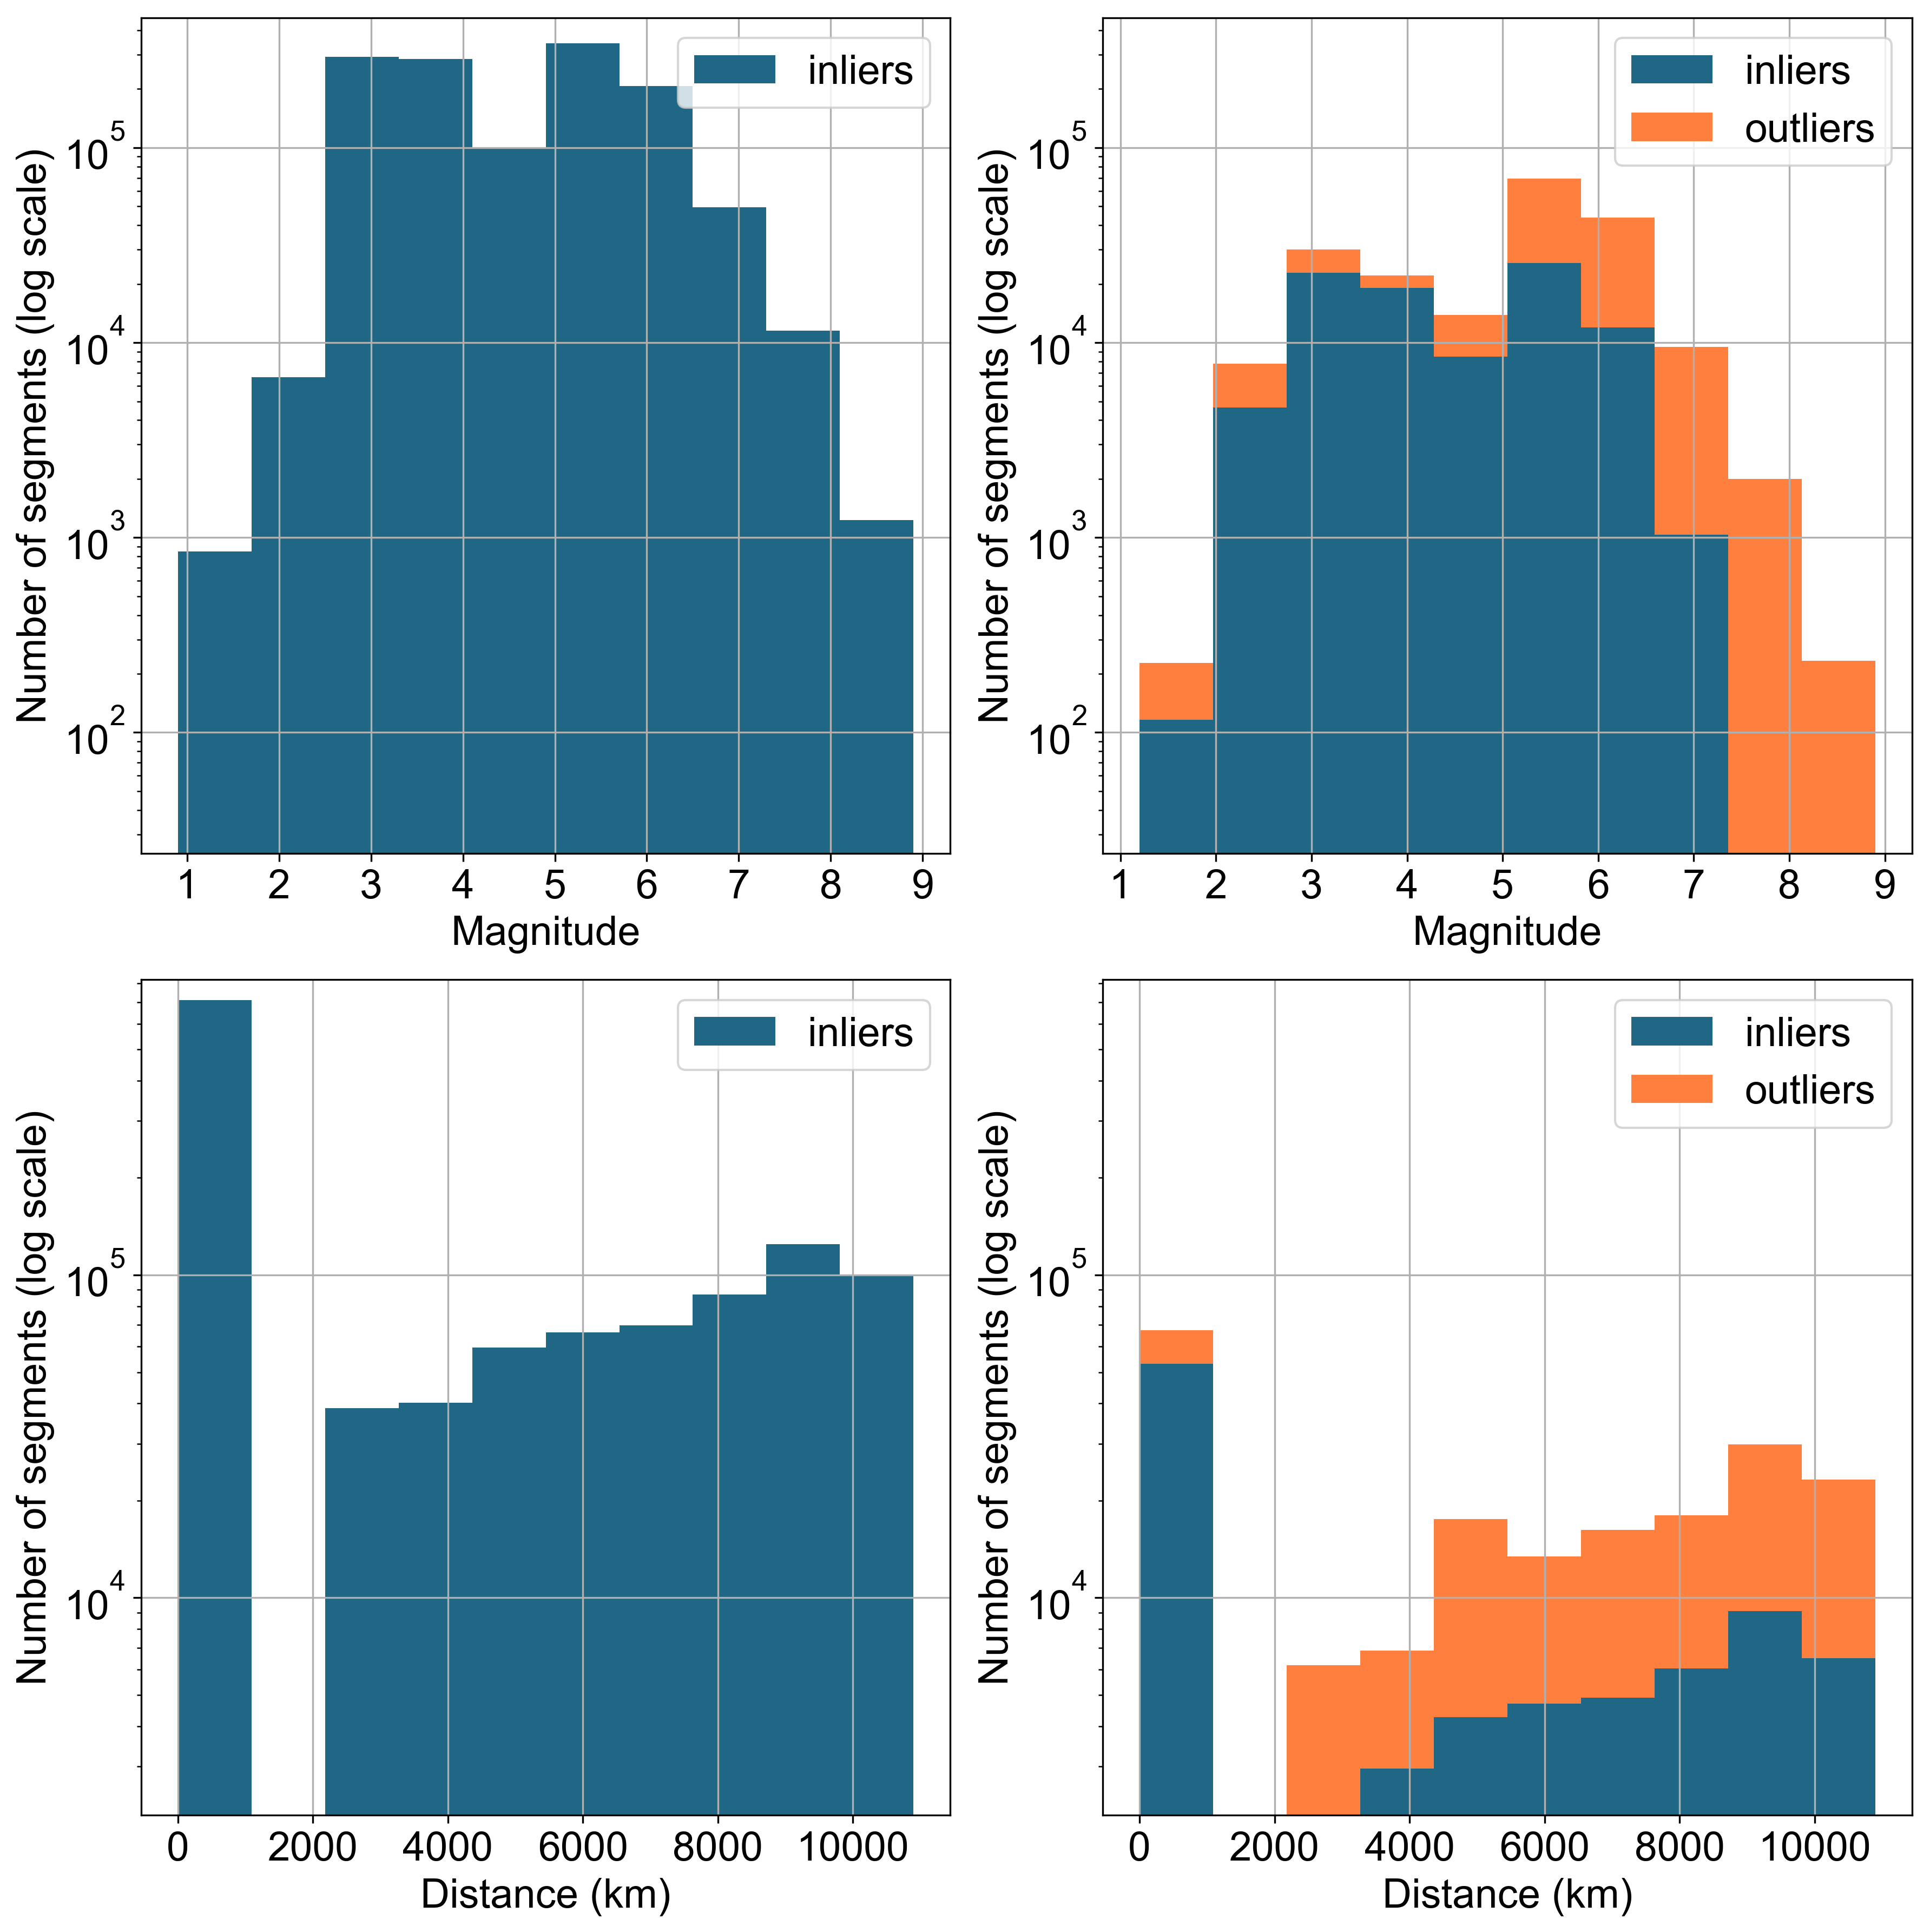

In [3]:
# Plot distributions
import sod.core.dataset as sod_dataset
import numpy as np

dinfo = sod_dataset.dataset_info(allset_test)
class_sel_i = dinfo.class_selector[dinfo.classnames[0]]
class_sel_o = dinfo.class_selector[dinfo.classnames[1]]

bins_m = None # np.arange(0, 10, 0.5)

# use colors which are ok also for grayscale:
colors = ['#1f6784', '#ff7f3e', '#9cf09c']

with plotparams({'figure.figsize': (12, 12), 'font.size': 18, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):
    fig, ax = plt.subplots(2, 2)
    ax[0][0].hist(allset_train.magnitude, bins=bins_m, label='inliers', log=True, color=colors[0])
    ax[1][0].hist(allset_train.distance_km, label='inliers', log=True, color=colors[0])
    data = {
        'inliers': allset_test[class_sel_i(allset_test)],
        'outliers': allset_test[class_sel_o(allset_test)],
    }
    ax[0][1].hist([_.magnitude for _ in data.values()], bins=bins_m, label=data.keys(), log=True, stacked=True,
                  color=colors[:len(data)])
    ax[1][1].hist([_.distance_km for _ in data.values()], label=data.keys(), log=True, stacked=True,
                  color=colors[:len(data)])
    for _, xlabel in zip(ax, ['Magnitude', 'Distance (km)']):
        miny, maxy = 1e6, 1
        for a in _:
            a.legend()
            a.grid()
            maxy = max(a.get_ylim()[1], maxy)
            miny = min(a.get_ylim()[0], miny)
            a.set_ylabel('Number of segments (log scale)')
            a.set_xlabel(xlabel)
        for a in _:
            a.set_ylim([miny, maxy])

plt.tight_layout()

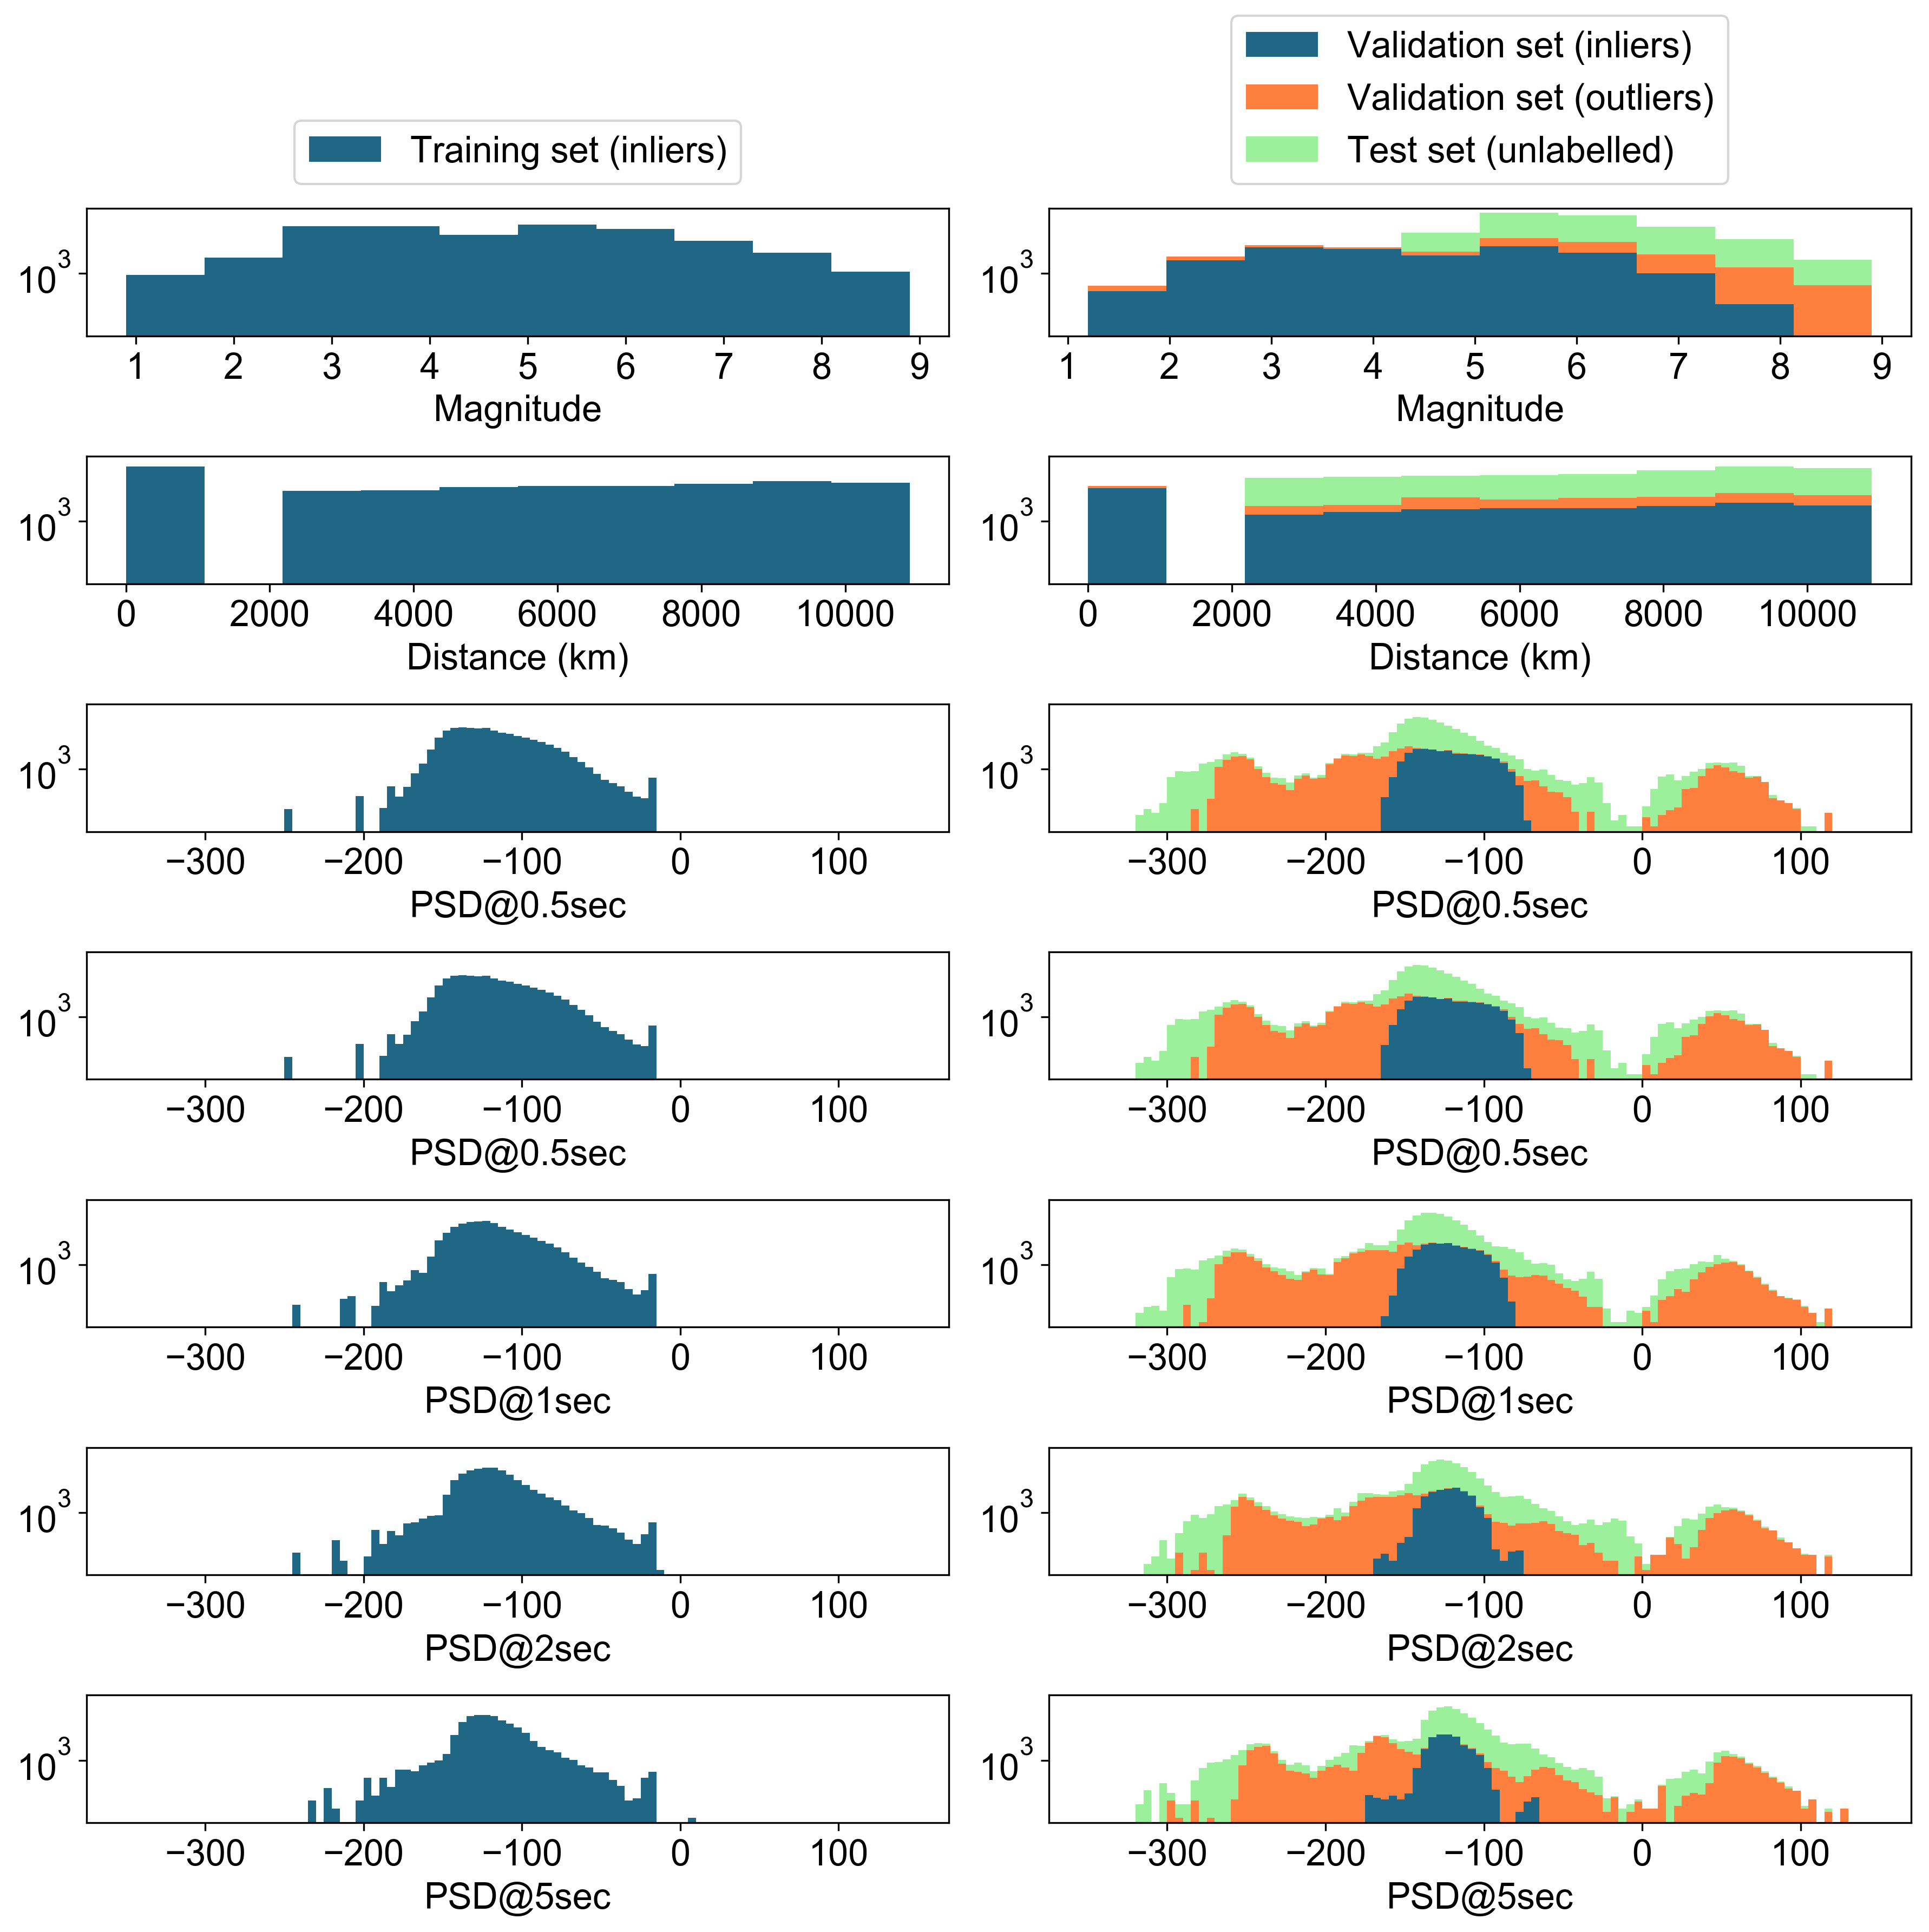

In [12]:
import importlib
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
import sod.core.dataset as sod_dataset
importlib.reload(sod_dataset)
import matplotlib.pyplot as plt
import numpy as np


bins = np.arange(-350, 150, 5)

dic = {
    'training set': allset_train,
    'test set': allset_test, 
}

labels = {
    'training set': {
        sod_dataset.dataset_info(allset_train).classnames[0]: 'Training set (inliers)'
    },
    'test set': {
        sod_dataset.dataset_info(allset_test).classnames[0]: 'Validation set (inliers)',
        sod_dataset.dataset_info(allset_test).classnames[1]: 'Validation set (outliers)',
        sod_dataset.dataset_info(allset_test).classnames[2]: 'Test set (unlabelled)'
    }
}

# use colors which are ok also for grayscale:
colors = ['#1f6784', '#ff7f3e', '#9cf09c']

features = ['magnitude', 'distance_km', 'psd@0.5sec', 'psd@0.5sec', 'psd@1sec', 'psd@2sec', 'psd@5sec']
featurelabels = ['Magnitude', 'Distance (km)', 'PSD@0.5sec', 'PSD@0.5sec', 'PSD@1sec', 'PSD@2sec', 'PSD@5sec']

axslist=[]
ylims = []

with plotparams({'figure.figsize': (12, 12), 'font.size': 16, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):
    fig, allaxs = plt.subplots(len(features), 2)
    # pltsubplots accepts also gridspec_kw to fix the subplots relative size, but apparently we do not
    # need it: , gridspec_kw={'height_ratios': [1] + [1]*(len(features)-1)})
    for i, col in enumerate(features):
        # print('artifacts on ok segments: %d' % len(dataframe_ok[col<-3000]))
        rowaxs = allaxs[i]
        for j, (name, datafr_) in enumerate(dic.items()):
            data = []
            label = []
            dinfo = sod_dataset.dataset_info(datafr_)
            for cname in dinfo.classnames:
                data.append(datafr_[dinfo.class_selector[cname](datafr_)][col])
                label.append(labels[name][cname])
            axs = rowaxs[j]
            axs.hist(data, bins=None if i < 2 else bins,
                     log=True, histtype='bar', stacked=True, label=label, color=colors[:len(data)])
            axylims = axs.get_ylim()
            ylims = [
                axylims[0] if not ylims else min(ylims[0], axylims[0]),
                axylims[1] if not ylims else max(ylims[1], axylims[1])
            ]
            axs.set_xlabel(featurelabels[i])
            if i == 0:
                axs.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05))

    for axrow in allaxs:
        for ax in axrow:
            ax.set_ylim(ylims)

plt.tight_layout()
plt.show()

In [ ]:
# STOP HERE FOR THE MOMENT ================================================================


Allset train


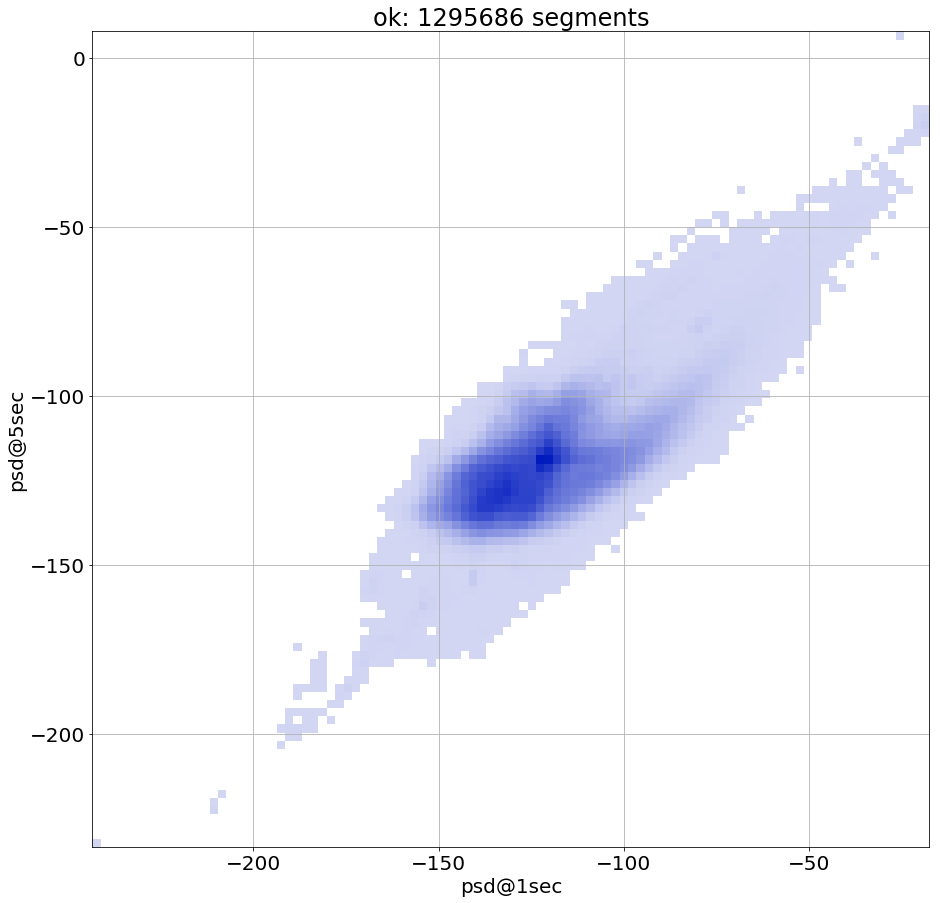

In [17]:
import importlib
import sod.core.plot as sod_plot
importlib.reload(sod_plot)


print()
print('Allset train')

with plotparams({'figure.figsize': (15, 15), 'font.size': 20}):
    fig = sod_plot.plot(allset_train, 'psd@1sec', 'psd@5sec', axis_lim=None)


Allset test


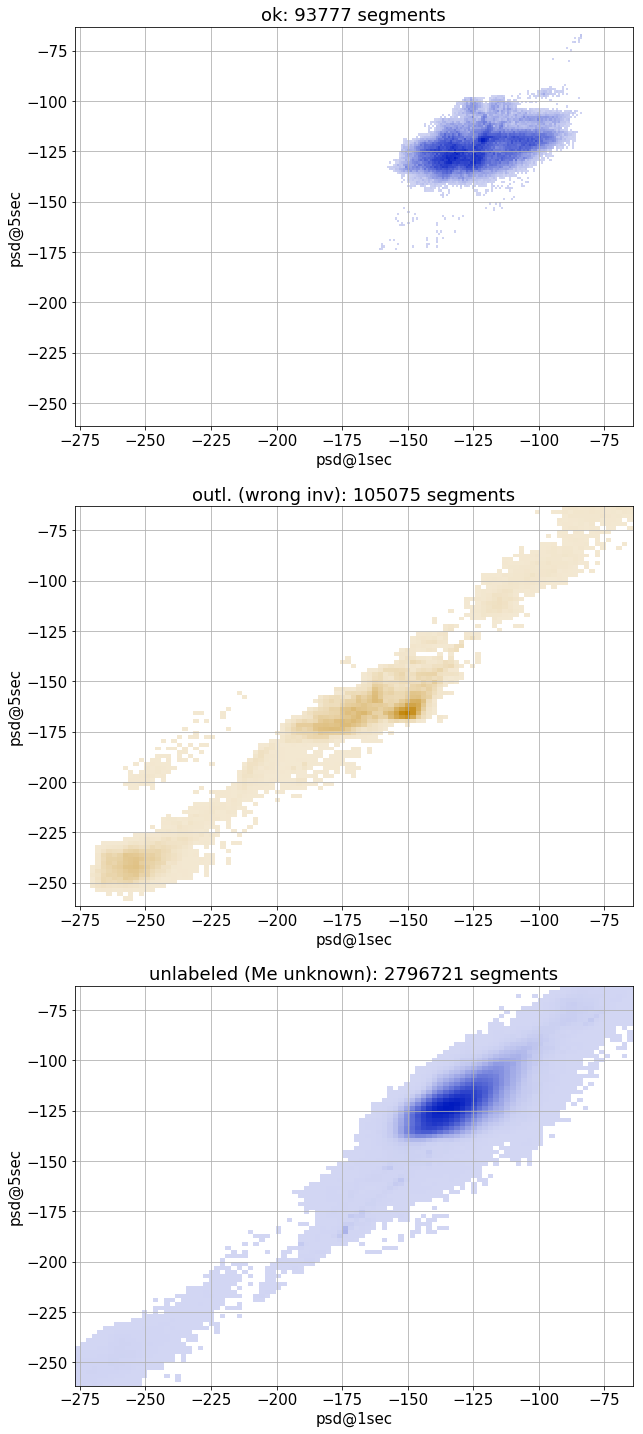

In [37]:
import importlib
import sod.core.plot as sod_plot
importlib.reload(sod_plot)

print()
print('Allset test')
with plotparams({'figure.figsize': (10, 25), 'font.size': 15}):
    fig = sod_plot.plot(allset_test, 'psd@1sec', 'psd@5sec', axis_lim=.994)

In [30]:
# Splitting train and test:
print('Splitting train and test')

cols = ['dataset_id', 'subclass', 'window_type', 'outlier', 'num_segments']

print('\nTrain (all inliers): %d segments' % len(allset_train))
print()
printdfr = []
for _, df_ in allset_train.groupby(cols[:-1]):
    printdfr.append({**{cols[i]: _[i] for i in range(len(cols)-1)}, **{cols[-1]: len(df_)}})
print(pd.DataFrame(printdfr, columns=cols).to_string(index=False))

print('\nTest (others): %d segments' % len(allset_test))
print()
printdfr = []
for _, df_ in allset_test.groupby(cols[:-1]):
    printdfr.append({**{cols[i]: _[i] for i in range(len(cols)-1)}, **{cols[-1]: len(df_)}})
print(pd.DataFrame(printdfr, columns=cols).to_string(index=False))


Splitting train and test

Train (all inliers): 1295742 segments

dataset_id subclass window_type  outlier  num_segments
         1                    n    False        307319
         1                    s    False        307316
         2                         False        582997
         3                         False         98110

Test (others): 2997672 segments

dataset_id                                  subclass window_type  outlier  num_segments
         1                                                     a     True         11389
         1                                                     n    False         21387
         1                                                     s    False         21391
         1  INVFILE:CH.GRIMS.2011-11-09T00:00:00.xml           n     True             3
         1  INVFILE:CH.GRIMS.2011-11-09T00:00:00.xml           s     True             3
         1  INVFILE:CH.GRIMS.2015-10-30T10:50:00.xml           n     True           747
         1

In [33]:
for c in allset_train.columns:
    print(c + ': ' + str(allset_train[c].dtype))

allset_train.id: int64
dataset_id: int64
psd@0.05sec: float64
psd@0.1sec: float64
psd@0.2sec: float64
psd@0.5sec: float64
psd@1sec: float64
psd@2sec: float64
psd@3sec: float64
psd@5sec: float64
psd@9sec: float64
outlier: bool
subclass: category
window_type: category
amplitude_ratio: float64
event_id: int64
station_id: int64
event_time: datetime64[ns]
channel_code: category
magnitude: float64
distance_km: float64
location_code: category


In [ ]:
import importlib
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
import sod.core.dataset as sod_dataset
importlib.reload(sod_dataset)
import matplotlib.pyplot as plt
import numpy as np

# matplotlib stuff (used below) =====================================
import matplotlib.pyplot as plt
from contextlib import contextmanager
@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v

# =====================================================================
bins = np.arange(-3100, 1000, 10)

for caption, dataframe in [
    ('allset_test', allset_test),
    ('allset_train', allset_train),
    ]:
    dinfo = sod_dataset.dataset_info(dataframe)
    for col in ['psd@0.5sec', 'psd@0.5sec', 'psd@1sec', 'psd@2sec', 'psd@5sec']:
        # print('artifacts on ok segments: %d' % len(dataframe_ok[col<-3000]))

    # This prints the artifacts. Uncomment if you want to show them.
    # We inspected them and they are issued from a miniSeed with all constant (relatively high)
    # values. WHAT IS THE CAUSE?
    # dataframe_ok = dataframe[dinfo.class_selector[dinfo.classnames[0]](dataframe)]
    # dataframe_artifacts = dataframe_ok[col < -3000]
    # for (staid, did, segid), _ in dataframe_artifacts.groupby(['station_id', 'dataset_id', 'allset.id']):
    #     print('dataset id: %d, station id: %d, segment id: %d' % (did, staid, segid))
        data = []
        label = []
        for cname in dinfo.classnames:
            data.append(dataframe[dinfo.class_selector[cname](dataframe)][col])
            label.append(caption +  "(class: " + cname + ")")
        
        # bins = np.arange(int(np.nanmin(col)-10), int(np.nanmax(col)+10), 10)

        with plotparams({'figure.figsize': (15, 5)}):
            plt.hist(data, bins, log=True, histtype='bar', stacked=True, label=label)
            # print(_)
            # raise
            plt.title(col)
            plt.legend()
            plt.show()